## COLLECT DATA

### collect market data using binance api


In [15]:
from binance.client import Client

client = Client()
exchange_info = client.get_exchange_info()

print(f"market info: {len(exchange_info['symbols'])}")


market info: 2873


### fetch curent market data for all trading pairs which would later be filtered

In [16]:
import pandas as pd

tickers = client.get_ticker()
tickers_df = pd.DataFrame(tickers).set_index('symbol')
tickers_df['quoteVolume'] = pd.to_numeric(tickers_df['quoteVolume'])

print(tickers_df.head(5))

         priceChange priceChangePercent weightedAvgPrice prevClosePrice  \
symbol                                                                    
ETHBTC   -0.00028000             -0.751       0.03700060     0.03725000   
LTCBTC    0.00004300              3.805       0.00115462     0.00112900   
BNBBTC   -0.00004700             -0.648       0.00722137     0.00725200   
NEOBTC   -0.00000060             -0.371       0.00016154     0.00016210   
QTUMETH   0.00000900              0.962       0.00094830     0.00093400   

          lastPrice       lastQty    bidPrice        bidQty    askPrice  \
symbol                                                                    
ETHBTC   0.03698000    0.00570000  0.03697000   39.76010000  0.03698000   
LTCBTC   0.00117300    6.52900000  0.00117200  254.09500000  0.00117300   
BNBBTC   0.00720600    0.06200000  0.00720500   20.37300000  0.00720600   
NEOBTC   0.00016110    5.53000000  0.00016110   21.60000000  0.00016120   
QTUMETH  0.00094500  813

### setup cache and data directories for data collected

In [17]:
from os import makedirs


cache_dir = "./.cache"
data_dir = "./data"
makedirs(cache_dir, exist_ok=True)
makedirs(data_dir, exist_ok=True)

### setup cache and make requests in batches 
- to avoid rate limiting
- to speed up the process
- to avoid redundant requests


In [18]:
from joblib import Memory
import pandas as pd
import requests
import certifi

memory = Memory(cache_dir)

BATCH_SIZE = 30
SLEEP_TIME = 1


### filter market data
why these filters?
- MAX_DAYS: to avoid data that is too old (90 days)
- MIN_VOLUME: to avoid data that is too low (50,000 USDT)
- MAX_VOLUME: to avoid data that is too high (10,000,000 USDT)
- MIN_MARKET_CAP: to avoid data that is too low (1,000,000 USDT)
- MAX_MARKET_CAP: to avoid data that is too high (100,000,000 USDT) as requested in the assigment


In [19]:
MARKET_FILTERS = {
    'MAX_DAYS': 90,
    'MIN_VOLUME': 50_000,
    'MAX_VOLUME': 10_000_000,
    'MIN_MARKET_CAP': 1_000_000,
    'MAX_MARKET_CAP': 100_000_000
}

### filter market data for USDT pairs and volume

In [20]:
# fetch market cap data from binance. found the link in some stackoverflow post on how to fetch market cap data.
url = "https://www.binance.com/bapi/apex/v1/friendly/apex/marketing/complianceSymbolList"

response = requests.get(
    url,
    headers={"Accept-Encoding": "gzip"},
    verify=certifi.where()
)
data = response.json()

from pprint import pprint

pprint(data.get('data', [])[0])

{'allTimeHighDate': None,
 'allTimeHighPrice': None,
 'allTimeHighSource': None,
 'allTimeLowDate': None,
 'allTimeLowPrice': None,
 'allTimeLowSource': None,
 'baseAsset': '1000CAT',
 'circulatingSupply': 6749954687,
 'cmcUniqueId': 32724,
 'dayChange': -2.57303237,
 'dayChangeAmount': 5.853e-05,
 'explorerUrls': None,
 'fullName': '1000*Simons Cat',
 'fullyDilutedMarketCap': 322021849.5,
 'hidden': 1,
 'highLight': 0,
 'id': 585024111,
 'imageUrl': None,
 'issueDate': None,
 'issuePrice': None,
 'issuePriceUsed': None,
 'legalMoney': 0,
 'listingCountdown': 0,
 'listingTime': 1734426000000,
 'localFullName': '1000*Simons Cat',
 'logo': 'https://bin.bnbstatic.com/image/admin_mgs_image_upload/20241216/4eb3b103-b10f-4290-a496-9ed97644c17c.png',
 'mapperName': 'CAT',
 'marketCap': 241514765.810159,
 'marketCapDominance': None,
 'maxSupply': 9000000000,
 'name': '1000CAT',
 'onlyFutures': None,
 'planToOpenMarketTime': 1734426000000,
 'preMarketEndTime': None,
 'price': 3.5780205500177e-0

In [21]:
# create DataFrame with filtered market cap data
symbol_data = [
    {'symbol': asset.get('symbol', ''), 'marketCap': asset.get('marketCap')}
    for asset in data.get('data', [])
    if 'USDT' in asset.get('symbol', '') and asset.get('marketCap') is not None
]


market_cap_df = pd.DataFrame(symbol_data).set_index('symbol')

print(market_cap_df.head)

<bound method NDFrame.head of                    marketCap
symbol                      
1000CATUSDT     2.415148e+08
1000SATSUSDT    3.980380e+08
1INCHUSDT       5.999870e+08
1MBABYDOGEUSDT  5.423024e+08
AAVEUSDT        5.142909e+09
...                      ...
ZENUSDT         4.365526e+08
ZILUSDT         4.460714e+08
ZKUSDT          7.831524e+08
ZROUSDT         6.371472e+08
ZRXUSDT         4.523956e+08

[388 rows x 1 columns]>


In [22]:
# get usdt pairs
valid_pairs = pd.DataFrame(exchange_info['symbols'])
valid_pairs = valid_pairs[
    (valid_pairs['symbol'].str.endswith('USDT')) & 
    (valid_pairs['status'] == 'TRADING')
]['symbol']

# filter by volume (50k to 10M)
volume_mask = tickers_df['quoteVolume'].between(50_000, 10_000_000)
volume_filtered = tickers_df[tickers_df.index.isin(valid_pairs) & volume_mask]

# merge volume and market cap data
combined_df = volume_filtered.join(market_cap_df)

# apply market cap filter (1M to 100M)
market_cap_mask = combined_df['marketCap'].between(1_000_000, 100_000_000)
filtered_pairs = combined_df[market_cap_mask]

print(f"Found {len(filtered_pairs)} pairs meeting all criteria")
display(filtered_pairs.head())

Found 100 pairs meeting all criteria


,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,askQty,...,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count,marketCap
symbol,,,,,,,,,,,,,,,,,,,,,
NULSUSDT,-0.00170000,-0.399,0.42332451,0.42530000,0.42420000,60.00000000,0.42420000,859.00000000,0.42460000,14.00000000,...,0.42980000,0.41710000,1280507.00000000,5.420700e+05,1736037088687,1736123488687,38962767,38974730,11964,4.718479e+07
COSUSDT,0.00008000,0.981,0.00823766,0.00816600,0.00823700,910.40000000,0.00823800,10843.60000000,0.00823900,910.50000000,...,0.00838700,0.00805600,406685698.70000000,3.350138e+06,1736037089561,1736123489561,59828803,59879800,50998,4.266265e+07
MTLUSDT,0.02400000,1.948,1.24909387,1.23400000,1.25600000,259.90000000,1.25500000,2375.50000000,1.25600000,103.20000000,...,1.27400000,1.22300000,1284514.50000000,1.604479e+06,1736037089512,1736123489512,52255478,52274602,19125,9.902103e+07
WANUSDT,-0.00290000,-1.210,0.23743755,0.23970000,0.23680000,633.00000000,0.23680000,132.00000000,0.23700000,484.00000000,...,0.24040000,0.23430000,1582173.00000000,3.756673e+05,1736037084284,1736123484284,23578632,23588143,9512,4.707235e+07
FUNUSDT,-0.00005100,-1.043,0.00484902,0.00489200,0.00484100,1953.00000000,0.00483700,8922.00000000,0.00484100,92740.00000000,...,0.00491000,0.00478600,208986519.00000000,1.013380e+06,1736037085313,1736123485313,38812781,38830051,17271,5.288191e+07


In [23]:
@memory.cache
def get_klines_cached(symbol, interval='15m', limit=100):
    return client.get_klines(symbol=symbol, interval=interval, limit=limit)

### collect eligible symbols in batches
for each potential symbol:
- check token age(days) using klines
- calculate market cap
- filter market cap
- collect data

In [24]:
import time

candidates_data = []

# split symbols into batches
symbols = filtered_pairs.index.tolist()
batches = [symbols[i:i + BATCH_SIZE] for i in range(0, len(symbols), BATCH_SIZE)]

for batch in batches:
    for symbol in batch:
        try:
            # get historical data
            klines = get_klines_cached(symbol, "1d", 90)
            
            # data quality checks
            if len(klines) < 7:  # Minimum 7 days of data
                print(f"Skipping {symbol}: Insufficient historical data")
                continue
                
            # convert klines to DataFrame with all columns
            df = pd.DataFrame(klines, columns=[
               'timestamp', 'open', 'high', 'low', 'close', 'volume',
                    'close_time', 'quote_volume', 'trades',
                    'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
            ])
            
            # convert numeric columns
            numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_volume']
            df[numeric_cols] = df[numeric_cols].astype(float)
            
            # check for gaps in data
            if df['volume'].isna().any() or (df['volume'] == 0).any():
                print(f"Skipping {symbol}: Contains missing or zero volume data")
                continue
                
            # check for consistent trading (volume stability)
            vol_mean = df['volume'].mean()
            vol_std = df['volume'].std()
            if vol_std / vol_mean > 3:  # Coefficient of variation > 3
                print(f"Skipping {symbol}: Highly irregular trading volume")
                continue

            market_cap = filtered_pairs.loc[symbol, 'marketCap']
            volume_24h = filtered_pairs.loc[symbol, 'quoteVolume']

            candidates_data.append({
                'symbol': symbol,
                'days_listed': len(klines),
                'market_cap': market_cap,
                'volume_24h': volume_24h,
                'avg_daily_volume': vol_mean,
                'volume_stability': vol_std / vol_mean
            })

        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
            continue
    
    time.sleep(SLEEP_TIME)

if candidates_data:
    candidates_df = pd.DataFrame(candidates_data).set_index('symbol')
else:
    candidates_df = pd.DataFrame(columns=['days_listed', 'market_cap', 'volume_24h', 
                                        'avg_daily_volume', 'volume_stability'])

print(f"Found {len(candidates_df)} final candidates")
display(candidates_df.head())

________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-1282771425.get_klines_cached...
get_klines_cached('IDEXUSDT', '1d', 90)
________________________________________________get_klines_cached - 0.5s, 0.0min
Found 100 final candidates


,days_listed,market_cap,volume_24h,avg_daily_volume,volume_stability
symbol,,,,,
NULSUSDT,90,4.718479e+07,5.420700e+05,6.141314e+06,0.959121
COSUSDT,90,4.266265e+07,3.350138e+06,7.755976e+08,1.387589
MTLUSDT,90,9.902103e+07,1.604479e+06,2.863680e+06,1.090659
WANUSDT,90,4.707235e+07,3.756673e+05,4.453935e+06,1.300440
FUNUSDT,90,5.288191e+07,1.013380e+06,6.917946e+08,2.106269


### collect historical data on eligible symbols


#### time frame choice:
- the proposed 10m time frame for granularity could not be fetched since Binance API doesn't support it.
- the closest granularity that can be fetched is 15m
- data collected should be sufficient for the training of the model


In [25]:
def get_latest_data(symbol: str) -> pd.DataFrame:
    """Get latest historical data from cache if available"""
    files = [f for f in os.listdir(data_dir) 
             if f.startswith(f'historical_{symbol}_')]
    
    if not files:
        return None
    
    latest_file = sorted(files)[-1]
    return pd.read_csv(
        f"{data_dir}/{latest_file}", 
        index_col='timestamp', 
        parse_dates=True
    )

In [26]:
from datetime import datetime

interval = "15m"
max_days = 90
historical_data = {}

for symbol in candidates_df.index:
    try:
        cached_df = get_latest_data(symbol)
        
        if cached_df is not None:
            # update existing data
            last_timestamp = cached_df.index[-1]
            new_klines = get_klines_cached(
                symbol=symbol,
                interval=interval,
                limit=100  
            )
            
            # convert klines to DataFrame
            new_df = pd.DataFrame(new_klines, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades',
                'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
            ])
            
            # convert timestamp to datetime
            new_df['timestamp'] = pd.to_datetime(new_df['timestamp'], unit='ms')
            new_df.set_index('timestamp', inplace=True)
            
            numeric_columns = ['open', 'high', 'low', 'close', 'volume', 
                             'quote_volume', 'trades', 'taker_buy_volume', 
                             'taker_buy_quote_volume']
            
            # convert numeric columns to float
            for col in numeric_columns:
                new_df[col] = pd.to_numeric(new_df[col])
            
            # concat existing and new data
            historical_data[symbol] = pd.concat([
                cached_df,
                new_df[new_df.index > last_timestamp]
            ]).drop_duplicates()
            
        else:
            # fetch new data
            klines = get_klines_cached(
                symbol=symbol,
                interval=interval,
                limit=max_days * 24
            )

    
            df = pd.DataFrame(klines, columns=[
                'timestamp', 'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_volume', 'trades',
                'taker_buy_volume', 'taker_buy_quote_volume', 'ignore'
            ])
            
            # convert timestamp to datetime
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('timestamp', inplace=True)
            
            # convert numeric columns to float
            numeric_columns = ['open', 'high', 'low', 'close', 'volume', 
                             'quote_volume', 'trades', 'taker_buy_volume', 
                             'taker_buy_quote_volume']

            # convert numeric columns to float
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col])
                    
            historical_data[symbol] = df

    except Exception as e:
        print(f"Error fetching history for {symbol}: {str(e)}")

print(f"Fetched historical data for {len(historical_data)} symbols")

# Optional: Save the data
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
for symbol, df in historical_data.items():
    df.to_csv(f'{data_dir}/historical_{symbol}_{timestamp}.csv')

________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-1282771425.get_klines_cached...
get_klines_cached(symbol='NULSUSDT', interval='15m', limit=2160)
________________________________________________get_klines_cached - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-1282771425.get_klines_cached...
get_klines_cached(symbol='COSUSDT', interval='15m', limit=2160)
________________________________________________get_klines_cached - 0.7s, 0.0min
________________________________________________________________________________
[Memory] Calling __main__--var-folders-2m-46s827d11c138msl2pcj2_4m0000gn-T-ipykernel-1282771425.get_klines_cached...
get_klines_cached(symbol='MTLUSDT', interval='15m', limit=2160)
________________________________________________get

## FEATURE ENGINEERING

### feature params
- volatility_window: 10
- volume_ma_window: 7
- rsi_window: 12

In [91]:
from dataclasses import dataclass

@dataclass
class Features:
    volatility_window: int = 24
    volume_ma_window: int = 48
    rsi_window: int = 96

params = Features()

### calculate features

In [92]:
import numpy as np
# df = pd.DataFrame.from_dict(historical_data)

# print("type:", type(historical_data))

# if isinstance(historical_data, dict):
#     fk = list(historical_data.keys())[0]
#     print("check value:", historical_data[fk])

feature_dfs = {}

# Feature selection based on correlation analysis and distributions
for symbol, df in historical_data.items():
    print(f"preprocessing {symbol}...")
    features = pd.DataFrame(index=df.index)
    
    # 1. returns - key independent signal, normal distribution
    # essentially, capture the price movement
    features['returns'] = np.log(df['close'] / df['close'].shift(1))
    
    # Volatility (6h window)
    ranges = pd.concat([
        df['high'] - df['low'],
        (df['high'] - df['close'].shift(1)).abs(),
        (df['low'] - df['close'].shift(1)).abs()
    ], axis=1)
    features['volatility'] = ranges.max(axis=1).rolling(params.volatility_window).mean()
    
    # Volume (12h MA)
    volume_ma = df['volume'].rolling(params.volume_ma_window).mean()
    raw_intensity = df['volume'] / volume_ma
    features['volume_intensity'] = np.log1p(raw_intensity)
    
    # RSI (24h)
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(params.rsi_window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(params.rsi_window).mean()
    features['rsi'] = 100 - (100 / (1 + gain / loss))
    
    
    feature_dfs[symbol] = features.dropna()

for symbol, features in feature_dfs.items():
    print(f"\n{symbol}:")
    print(f"shape: {features.shape}")
    print("features:", features.columns.tolist())
    print("\nfirst few rows:")
    print(features.head())
    break 

preprocessing NULSUSDT...
preprocessing COSUSDT...
preprocessing MTLUSDT...
preprocessing WANUSDT...
preprocessing FUNUSDT...
preprocessing NKNUSDT...
preprocessing ARPAUSDT...
preprocessing VITEUSDT...
preprocessing OGNUSDT...
preprocessing BNTUSDT...
preprocessing LTOUSDT...
preprocessing MBLUSDT...
preprocessing DATAUSDT...
preprocessing ARDRUSDT...
preprocessing MDTUSDT...
preprocessing STMXUSDT...
preprocessing KMDUSDT...
preprocessing DIAUSDT...
preprocessing FIOUSDT...
preprocessing BELUSDT...
preprocessing WINGUSDT...
preprocessing FLMUSDT...
preprocessing ALPHAUSDT...
preprocessing HARDUSDT...
preprocessing AVAUSDT...
preprocessing JUVUSDT...
preprocessing PSGUSDT...
preprocessing OGUSDT...
preprocessing ATMUSDT...
preprocessing ASRUSDT...
preprocessing FIROUSDT...
preprocessing LITUSDT...
preprocessing ACMUSDT...
preprocessing BADGERUSDT...
preprocessing FISUSDT...
preprocessing DEGOUSDT...
preprocessing ALICEUSDT...
preprocessing LINAUSDT...
preprocessing PERPUSDT...
preproc

### visualize feature selection
sample analysis on the first symbol

### correlation heatmap
initially, we will look at the correlation between features for a single symbol.

thoughts on feature selection:
- returns and volatility show no correlation
- volume intensity and returns are weakly correlated
- volume intensity and volatility are weakly correlated
- rsi and returns show relatively moderate correlation
  
it appears that the features set is well balanced and captures the price movement, volatility, volume, and momentum.


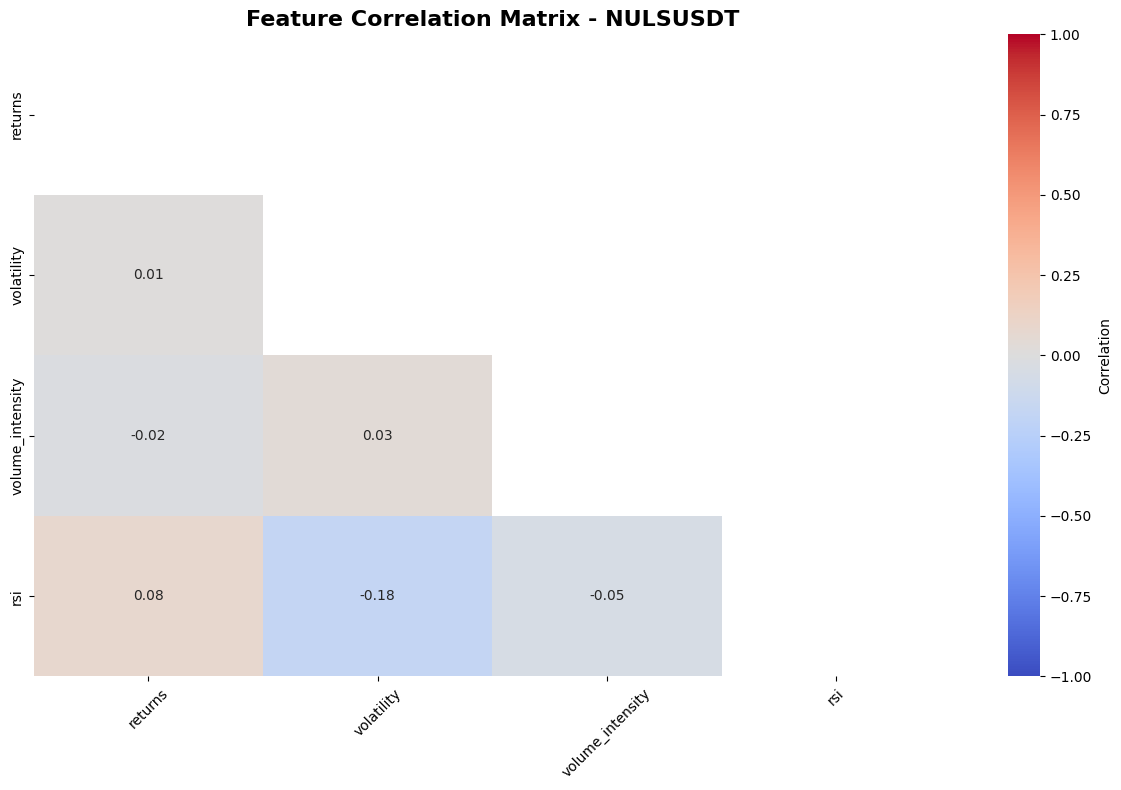

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

symbol = list(feature_dfs.keys())[0]  # first symbol
features = feature_dfs[symbol]

# correlation Heatmap
plt.figure(figsize=(12, 8))

corr_matrix = features.corr()

# craete heatmap
sns.heatmap(
    corr_matrix,
    annot=True,  # annotate with corr valuse
    fmt=".2f",   # limit to 2 decimal points
    mask=np.triu(np.ones_like(corr_matrix, dtype=bool)),  # show lower triangle
    cmap="coolwarm",  
    vmin=-1, vmax=1,  # correlation range
    center=0,
    cbar_kws={'label': 'Correlation'}  # add labels to color bar
)

plt.title(f'Feature Correlation Matrix - {symbol}', fontsize=16, weight='bold')
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

### feature distributions
thoughts on feature distributions:
- returns are normally distributed
- volatility is skewed to the right
- volume intensity is skewed to the right
- rsi is almost normally distributed. i mean its around 49.5 so that's good not bad


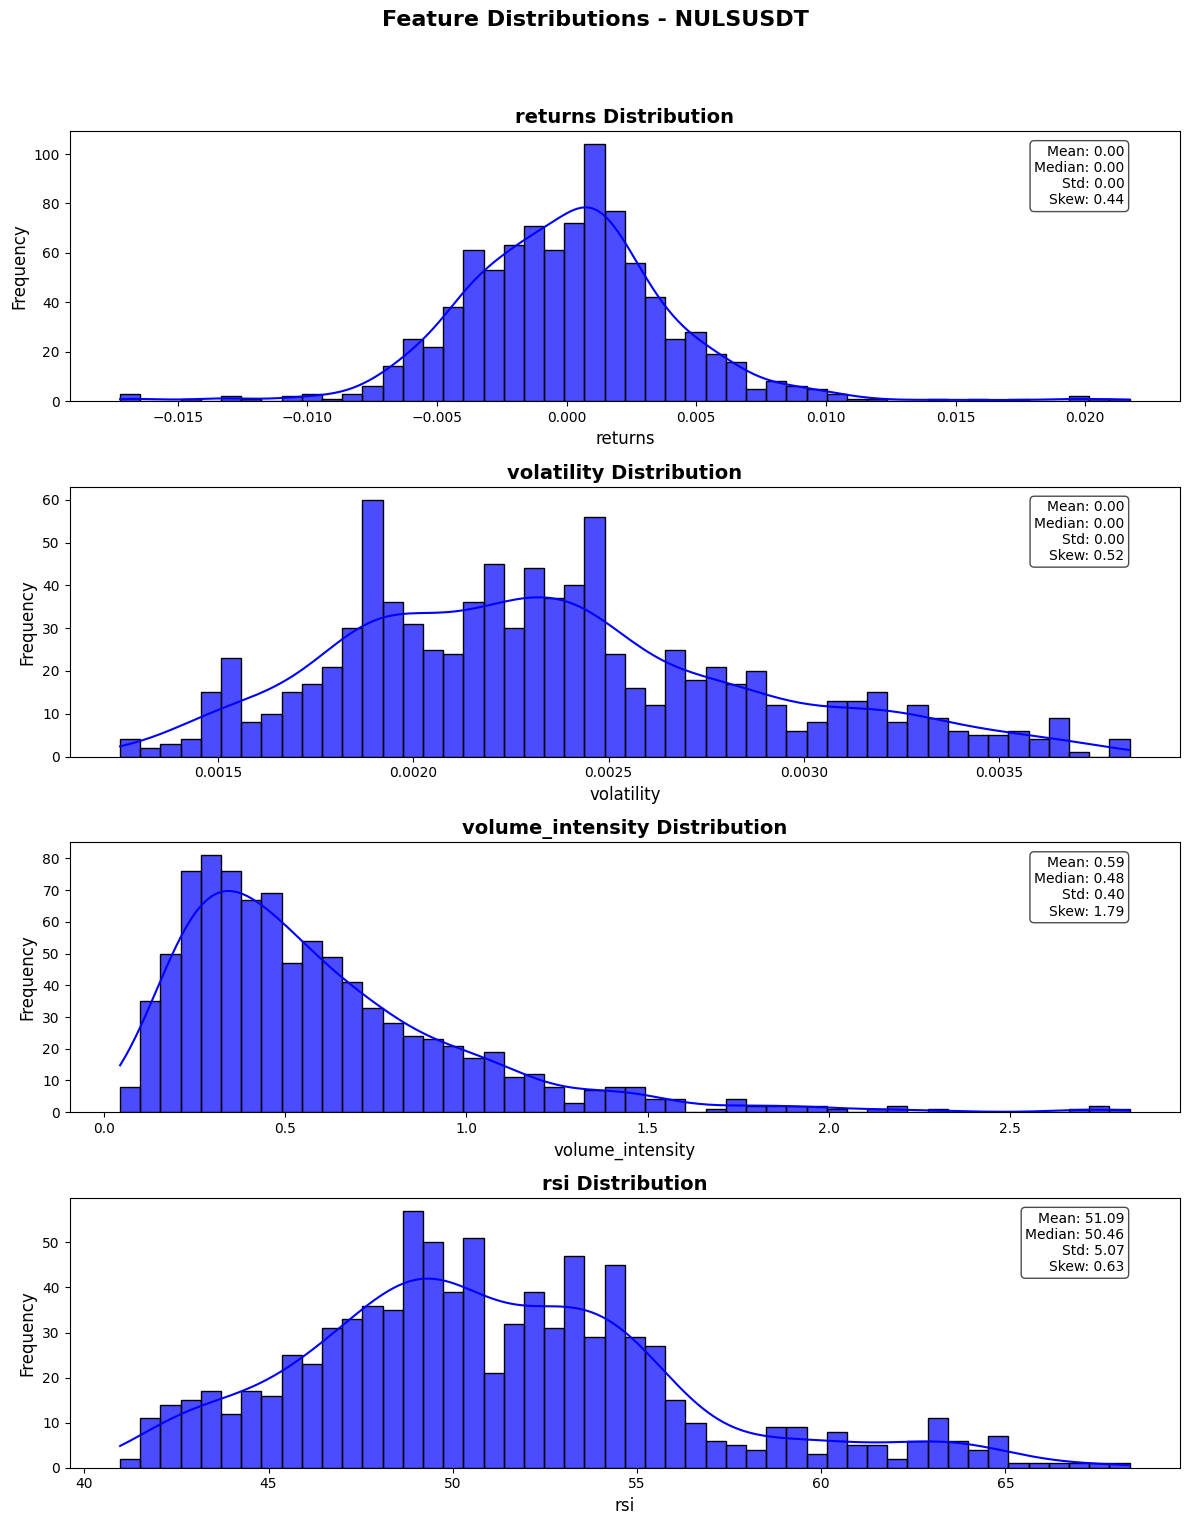

In [94]:
num_features = features.select_dtypes(include=np.number).columns  # select numerical features
features_subset = features[num_features]  # subset of numerical features

fig, axes = plt.subplots(len(features_subset.columns), 1, figsize=(12, len(features_subset.columns) * 4))

for i, feature in enumerate(features_subset.columns):
    ax = axes[i]
    sns.histplot(features_subset[feature], bins=50, kde=True, ax=ax, color='blue', alpha=0.7)
    ax.set_title(f'{feature} Distribution', fontsize=14, weight='bold')
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

    # add a text box with statistics
    mean = features_subset[feature].mean()
    median = features_subset[feature].median()
    std = features_subset[feature].std()
    skew = features_subset[feature].skew()
    ax.text(0.95, 0.95,
            f"Mean: {mean:.2f}\nMedian: {median:.2f}\nStd: {std:.2f}\nSkew: {skew:.2f}",
            transform=ax.transAxes,
            fontsize=10, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.suptitle(f'Feature Distributions - {symbol}', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # should be enough space for suptitle
plt.show()

In [95]:
# Show what features we have for one symbol
symbol = list(feature_dfs.keys())[0]
print(f"Example features for {symbol}:")
print("\nFeature DataFrame shape:", feature_dfs[symbol].shape)
print("\nFeature columns:")
print(feature_dfs[symbol].head())

Example features for NULSUSDT:

Feature DataFrame shape: (905, 4)

Feature columns:
                      returns  volatility  volume_intensity        rsi
timestamp                                                             
2024-12-27 14:30:00 -0.014149    0.003563          1.218866  51.460823
2024-12-27 14:45:00  0.003992    0.003567          0.639207  51.971091
2024-12-27 15:00:00 -0.002244    0.003187          0.708374  51.665578
2024-12-27 15:15:00 -0.008773    0.003179          0.668622  49.675325
2024-12-27 15:30:00 -0.002268    0.003033          0.493901  50.032701


In [96]:
# let's set up our training window (last 3 months)
from datetime import timedelta

def prepare_training_data(df: pd.DataFrame, training_days: int = 90) -> pd.DataFrame:
    """prepare training data with specified window"""
    end_date = df.index[-1]
    start_date = end_date - timedelta(days=training_days)
    return df[start_date:end_date]

In [97]:
# training data for one symbol
training_data = prepare_training_data(feature_dfs[symbol])
print(f"\ntraining data for {symbol}:")
print("period:", training_data.index[0], "to", training_data.index[-1])
print("observations:", len(training_data))


training data for NULSUSDT:
period: 2024-12-27 14:30:00 to 2025-01-06 00:30:00
observations: 905


In [98]:
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
from typing import List, Dict, Any

@dataclass
class HMMConfig:
    n_states: int = 3           # no. of hidden states
    n_iter: int = 150           # maximum iterations for training
    tol: float = 1e-5           # convergence tolerance
    random_seed: int = 42 
    init_params: str = "kmeans"

In [99]:
config = HMMConfig()

class HMMMarketCycle:
    """Gaussian Hidden Markov Model (HMM) for market cycle detection."""

    def __init__(self, config: HMMConfig, feature_columns: List[str]):
        self.config = config
        self.feature_columns = feature_columns
        self.model = hmm.GaussianHMM(
            n_components=config.n_states,
            covariance_type="diag",
            n_iter=config.n_iter,
            tol=config.tol,
            random_state=config.random_seed,
            init_params=config.init_params,     # kmeans is a good starting point, update later !!
        )
        self.scaler = StandardScaler()
        self.trained = False
        self.state_labels = []

In [100]:
def _validate_features(self, features: pd.DataFrame) -> None:
    """ensure the required features are present in the DataFrame"""
    missing_features = set(self.feature_columns) - set(features.columns)
    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

def _prepare_features(self, features: pd.DataFrame) -> np.ndarray:
    """validate and scale the feature data"""
    self._validate_features(features)
    X = features[self.feature_columns].values
    return self.scaler.fit_transform(X) if not self.trained else self.scaler.transform(X)

In [101]:
# Add methods to class
HMMMarketCycle._validate_features = _validate_features
HMMMarketCycle._prepare_features = _prepare_features

In [102]:
def train(self, data: pd.DataFrame) -> Dict[str, Any]:
    """train the HMM using the baum-welch algorithm and return model performance metrics"""
    X = self._prepare_features(data)
    self.model.fit(X)
    self.trained = True
    self.state_labels = self._assign_state_labels(X)

    metrics = {
        "log_likelihood": self.model.score(X),
        "n_iter": self.model.monitor_.iter,
        "converged": self.model.monitor_.converged,
        "aic": self._calculate_aic(X),
        "bic": self._calculate_bic(X),
    }
    return metrics

HMMMarketCycle.train = train

In [103]:
# note to self: before making predictions, i check if the model is trained. if it's not, raise an error.
# after ensuring the model is ready, i prepare the features and compute the state probabilities using `predict_proba()`.
# then, i predict the most likely state for each data point using `predict()`.
# i want the results to be in a DataFrame for easy access, where each row corresponds to the data points
# and each column holds the probability for a given state (e.g., bull, bear, neutral).
def predict(self, data: pd.DataFrame) -> pd.DataFrame:
    """predict the hidden states for the given data and return a DataFrame with state probabilities."""
    if not self.trained:
        raise RuntimeError("train the model first.")
    X = self._prepare_features(data)
    state_probs = self.model.predict_proba(X)
    states = self.model.predict(X)

    results = pd.DataFrame(state_probs, columns=[f"{label}_prob" for label in self.state_labels], index=data.index)
    results["state"] = [self.state_labels[state] for state in states]
    return results

HMMMarketCycle.predict = predict

In [104]:
# note to self: Here, I’m classifying the states based on their mean values of returns and volatility.
# the idea is to classify states into 'bull', 'bear', or 'neutral' based on these two features.
# i use the "returns" and "volatility" features to make the classification more intuitive:
# - Bull: High returns, low volatility
# - Bear: Low returns, high volatility
# - Neutral: Everything else (default case)
# first, get the predicted states, then compute the mean feature values for each state.
# use the median volatility to separate the bull and bear states from neutral ones.
def _assign_state_labels(self, X: np.ndarray) -> List[str]:
    """assign labels to states based on their features."""
    states = self.model.predict(X)
    state_means = np.array([X[states == i].mean(axis=0) for i in range(self.config.n_states)])
    returns_idx = self.feature_columns.index("returns")
    vol_idx = self.feature_columns.index("volatility")

    labels = []
    for i in range(self.config.n_states):
        if state_means[i, returns_idx] > 0 and state_means[i, vol_idx] < np.median(state_means[:, vol_idx]):
            labels.append("bull")
        elif state_means[i, returns_idx] < 0 and state_means[i, vol_idx] > np.median(state_means[:, vol_idx]):
            labels.append("bear")
        else:
            labels.append("neutral")
    return labels

HMMMarketCycle._assign_state_labels = _assign_state_labels

In [105]:
# note to self: AIC balances model fit and complexity.
# start by calculating the number of parameters (n_params), which depends on the number of states
# and the features involved. then, plug into the formula
# keep in mind, AIC doesn't penalize large datasets as much, so it's good for comparison.
def _calculate_aic(self, X: np.ndarray) -> float:
    """calculate the Akaike Information Criterion (AIC)."""
    n_params = self.config.n_states * (len(self.feature_columns) + self.config.n_states - 1)
    return -2 * self.model.score(X) + 2 * n_params


# useful for avoiding overfitting on large datasets since it penalizes complex models more heavily.
# like before, calculate n_params and substitute into the formula.
def _calculate_bic(self, X: np.ndarray) -> float:
    """calculate the Bayesian Information Criterion (BIC)."""
    n_params = self.config.n_states * (len(self.feature_columns) + self.config.n_states - 1)
    return -2 * self.model.score(X) + n_params * np.log(len(X))

HMMMarketCycle._calculate_aic = _calculate_aic
HMMMarketCycle._calculate_bic = _calculate_bic

In [106]:
# initialize model
feature_columns = ['returns', 'volatility', 'volume_intensity', 'rsi']
model = HMMMarketCycle(config, feature_columns)

In [107]:
print("training features:")
print(training_data[feature_columns].describe())

# train model
metrics = model.train(training_data[feature_columns])
print("\ntraining metrics:")
for metric, value in metrics.items():
    print(f"- {metric}: {value}")



# note to self: rsi range needs a bit of fine tuning. research on better approaches.


training features:
          returns  volatility  volume_intensity         rsi
count  905.000000  905.000000        905.000000  905.000000
mean     0.000049    0.002347          0.589638   51.091049
std      0.004147    0.000524          0.400659    5.067316
min     -0.017228    0.001250          0.044198   40.971168
25%     -0.002498    0.001946          0.307012   47.799386
50%      0.000000    0.002304          0.481370   50.464396
75%      0.002140    0.002658          0.756050   53.967254
max      0.021714    0.003833          2.830162   68.370607

training metrics:
- log_likelihood: -4262.561753290791
- n_iter: 116
- converged: True
- aic: 8561.123506581582
- bic: 8647.666335568181
